#Deep Learning Assignment-1
###Author: Rafeed Sultaan(s3763175)
#Task: Predicting the Pan Angle from the Head Pose Image Dataset using Classification

##Loading the Dataset From Google Drive

In [ ]:
 from google.colab import drive 
 drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHx8EWg29qERFCH24YvG1488V4HrnBh9d8G29xDHvaT4_r9uEzk_y0
Mounted at /content/drive


### Extracting the A1_data.zip File

In [ ]:
#Unzipping the Dataset A1_data.zip
!cp  /content/drive/'My Drive'/COSC2779/Assignment01/A1_data.zip .
!unzip -q -o A1_data.zip
!rm A1_data.zip
!ls

drive	  modified_data.zip  s1234567_predictions.csv  test_data.csv
__MACOSX  README.md	     sample_data	       train_data.csv


Extracting the images from modified_data.zip

In [ ]:
!unzip -q -o modified_data.zip
!rm modified_data.zip
!ls

drive	  modified_data  s1234567_predictions.csv  test_data.csv
__MACOSX  README.md	 sample_data		   train_data.csv


#Loading the Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image

from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import concatenate
from keras.layers import LeakyReLU

from keras.utils import plot_model



from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split



import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import keras
import keras as K
import glob
import tensorflow, tensorboard
import cv2
import imageio
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns



## Checking the contents of "train_data.csv" file which contains the image labels

In [ ]:

head_pose_data = pd.read_csv('train_data.csv',delimiter=',') 
head_pose_data.head(5)

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


Dropping the "person_id" and "series" information which are not needed to predict the tilt angles


In [ ]:
head_pose_data = head_pose_data.drop(columns=['person_id', 'series'])

Checking the contents of the file after dropping the columns

In [ ]:
head_pose_data.head(10)

,filename,tilt,pan
0,face_790.jpg,-15,30
1,face_2445.jpg,0,-75
2,face_2266.jpg,-15,-60
3,face_2713.jpg,0,-90
4,face_2016.jpg,15,-75
5,face_2522.jpg,30,60
6,face_1254.jpg,15,-15
7,face_2754.jpg,15,-45
8,face_201.jpg,30,-90
9,face_931.jpg,15,-30


Checking the datatypes of the file name, tilt and pan

In [ ]:
head_pose_data.dtypes

filename    object
tilt         int64
pan          int64
dtype: object

Converting the tilt column from integer to string for classification

In [ ]:
head_pose_data['tilt'] = head_pose_data['tilt'].map(str)
head_pose_data['pan'] = head_pose_data['pan'].map(str)

Checking the data type of tilt and the pan

In [ ]:
head_pose_data.dtypes

filename    object
tilt        object
pan         object
dtype: object

Checking the range of values unique in "unique"


In [ ]:
head_pose_data['pan'].unique()

array(['30', '-75', '-60', '-90', '60', '-15', '-45', '-30', '90', '15',
       '45', '0', '75'], dtype=object)

## Converting the images to grayscale and resizing it to (64,64)


*   Color images are not needed to identify head poses
*   It will reduce the complexity of the images, allowing us to use deeper networks



In [ ]:

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, (64,64) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)

Preparing the dataframe with image_path and pan labels



In [ ]:
image_list = []
for image_path in glob.glob("modified_data/*.jpg"):
    tokenized_image_path = image_path.split('/')
    #Got the filename from image_path by tokenizing
    filename = tokenized_image_path[1].strip()
    selectedRow = head_pose_data.loc[(head_pose_data['filename'] ==filename) ]
    # Selecting the images for the train set
    if selectedRow.empty == False:
      label = str(selectedRow.iloc[0]['pan'])
      image_list.append((image_path, label))  
#dataframe consists of the data with only the training data containing image path and tilt labels
dataframe = pd.DataFrame(data=image_list, columns=['image_path','label'])



image_list_with_filenames = []
for image_path in glob.glob("modified_data/*.jpg"):
    filename = image_path.split("/")[-1]
    image_list_with_filenames.append((image_path,filename))
#dataframe consists of the all the data's image and filename
dataframe_with_filenames = pd.DataFrame(data=image_list_with_filenames,columns=["image_path","filename"])



Checking the contents of the dataframe, I am going to use for training my model

In [ ]:
dataframe.head(5)



,image_path,label
0,modified_data/face_2056.jpg,-15
1,modified_data/face_994.jpg,0
2,modified_data/face_731.jpg,75
3,modified_data/face_2084.jpg,-75
4,modified_data/face_784.jpg,75


# Checking the Distribution of classes in the dataframe

Amount of Images in each class

In [ ]:
print ("Number of -15 pan poses " , len(dataframe[dataframe['label']=='-15']))
print ("Number of -30 pan poses  " , len(dataframe[dataframe['label']=='-30']))
print ("Number of -45 pan poses " , len(dataframe[dataframe['label']=='-45']))
print ("Number of -60 pan poses  ",len(dataframe[dataframe['label']=='-60']))
print ("Number of -75 pan poses ", len(dataframe[dataframe['label']=='-75']))
print ("Number of -90 pan poses ", len(dataframe[dataframe['label']=='-90']))

print ("Number of 0 pan poses ", len(dataframe[dataframe['label']=='0']))
print ("Number of 15 pan poses ", len(dataframe[dataframe['label']=='15']))
print ("Number of 30 pan poses ", len(dataframe[dataframe['label']=='30']))
print ("Number of 45 pan poses ", len(dataframe[dataframe['label']=='45']))
print ("Number of 60 pan poses ", len(dataframe[dataframe['label']=='60']))
print ("Number of 75 pan poses ", len(dataframe[dataframe['label']=='75']))
print ("Number of 90 pan poses ", len(dataframe[dataframe['label']=='90']))

Number of -15 pan poses  175
Number of -30 pan poses   175
Number of -45 pan poses  175
Number of -60 pan poses   175
Number of -75 pan poses  175
Number of -90 pan poses  175
Number of 0 pan poses  225
Number of 15 pan poses  175
Number of 30 pan poses  175
Number of 45 pan poses  175
Number of 60 pan poses  175
Number of 75 pan poses  175
Number of 90 pan poses  175


### Bar Chart of Class Balance for Pan Angles


*   Amount of the "0" degrees class labels is slightly higer than other classes
* All other classes have the same amount of classes.




Text(0.5, 1.0, 'Class Balance Diagram for Pan Angles')

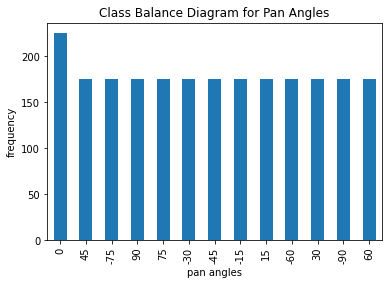

In [ ]:
ax = dataframe['label'].value_counts().plot(kind='bar')
ax.set_xlabel("pan angles")
ax.set_ylabel("frequency")
ax.set_title("Class Balance Diagram for Pan Angles")

Checking the images in the dataset, if the poses of the images can be recognized from the grayscale and resized images

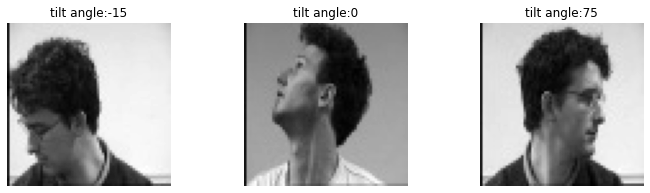

In [ ]:
from PIL import Image
random_image_list = dataframe.loc[np.random.choice(2325, 3),'image_path']
plt.figure(figsize=(12,3))
for i, image_path in enumerate(random_image_list ):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,3,i+1)
    plt.imshow(im,cmap='gray')
    plt.title("tilt angle:"+str(dataframe['label'][i]))
    plt.axis('off')  
plt.show()

#Using Holdout validation to split the data into train,test and validation sets 

In [ ]:
##Holdout data test_shapes
trainset, testset = train_test_split(dataframe, test_size=0.2)
trainset, validationset = train_test_split(trainset, test_size=0.2)

Amount of the data in the trainset,validationset and testset

In [ ]:
num_train_examples= trainset.shape[0]
num_val_examples = validationset.shape[0]
num_test_examples = testset.shape[0]

print("Number of data in the trainset:"+str(num_train_examples))
print("Number of data in the validationset:"+str(num_val_examples))
print("Number of data in the testset:"+str(num_test_examples ))



Number of data in the trainset:1488
Number of data in the validationset:372
Number of data in the testset:465


##Data Augmentation Using Vertical and Horizontal Shift in the trainset
* This is done to control overfitting of the data

*   Since we are dealing with rotations in headpose of data, it will change the  prediction of the images causing misclassification
*   Width-Shift range of 0.10 and Horizontal Shift range of 0.10 is used

## Creating the data for the model using  with Image_Data Generator
Experimented with other batch-size like [16,32,64] doesn't improve the 

*   Experimented with other batch-size like [16,32,64], doesn't improve the 
the performance.
*   Ended up taking BATCH_SIZE =16


In [ ]:
#Experimented with other batch-size like [16,32,64] doesn't improve the performance. So ended up taking batch size = 16 
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',width_shift_range=0.10,height_shift_range=0.10)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')



train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validationset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='categorical')

Found 1488 validated image filenames belonging to 13 classes.
Found 372 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.


evaluateModel() function prints Confution Matrix and Classification Report based on the test data from found from original head pose dataset

In [ ]:
def evaluateModel(model):
    test_generator.reset()
    Y_pred = model.predict_generator(test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['-15', '-30', '-45', '-60', '-75', '-90', '0', '15', '30', '45', '60', '75', '90']
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

displayPlots() function displays the Validation Accuracy/Loss vs Epoch graphs

In [ ]:
def displayPlots(history):
    ## Accuracy Graph
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    ##Loss Graph
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#LeNet with 2 Hidden Layers with SGD Optimizer 
- The model is **underfitting**
- Next, will try with Adam Optimizer

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_24 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_25 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)       

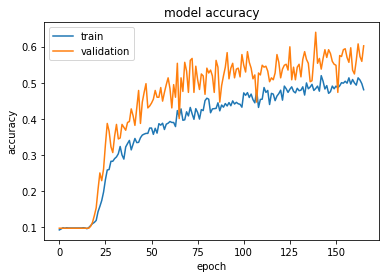

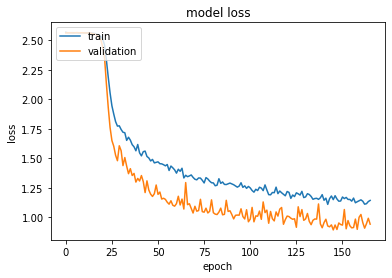

In [ ]:
LeNet1= Sequential()

# input
LeNet1.add(Input(shape=(64,64, 3)))
LeNet1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# input
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights


# Conv Layer 1
LeNet1.add(Conv2D(32, (3, 3)))
LeNet1.add(Activation('relu'))
LeNet1.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet1.add(Conv2D(32, (3, 3)))
LeNet1.add(Activation('relu'))
LeNet1.add(MaxPooling2D(pool_size=(2, 2)))




LeNet1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet1.add(Dense(64))
LeNet1.add(Activation('relu'))
LeNet1.add(Dropout(0.5))
LeNet1.add(Dense(13))
LeNet1.add(Activation('softmax'))

LeNet1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])

LeNet1.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )
# Evaluate the model on the original dataset
evaluateModel(LeNet1)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 2 Hidden Layers with Adam Optimizer
*   Adam Optimizer is a variation of SGD with adaptive learning rate
*   Adam has less tuneable parameter like momentum. So I am making the choice of Adam for the rest of them
*   It converges faster, so to prove my point I did my experiment with my base model LeNet

* It converged at epoch 140 compared to SGD which was 150
* The model is still **underfitting** need to increase the capacity by increasing the number of layers from 2 to 3

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_28 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)       

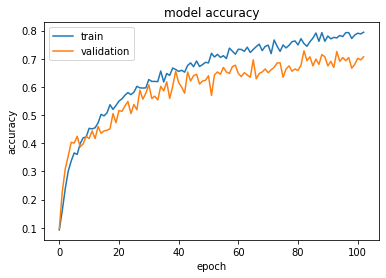

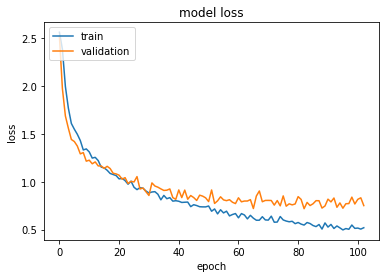

In [ ]:
LeNet2= Sequential()

# input
LeNet2.add(Input(shape=(64,64, 3)))
LeNet2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
LeNet2.add(Conv2D(32, (3, 3)))
LeNet2.add(Activation('relu'))
LeNet2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet2.add(Conv2D(32, (3, 3)))
LeNet2.add(Activation('relu'))
LeNet2.add(MaxPooling2D(pool_size=(2, 2)))




LeNet2.add(Flatten())  
LeNet2.add(Dense(64))
LeNet2.add(Activation('relu'))
LeNet2.add(Dense(13))
LeNet2.add(Activation('softmax'))

LeNet2.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

LeNet2.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )
# Evaluate the model on the original dataset
evaluateModel(LeNet2)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 3 Hidden Layers Dropout Adam Optimizer
- Dropout is used to make sure the network doesn't overfit even after adding more capacity
- The model is **not underfitting anymore**.
- The best Weighted average F1 Score 0.74 was achieved.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_32 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_33 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)       

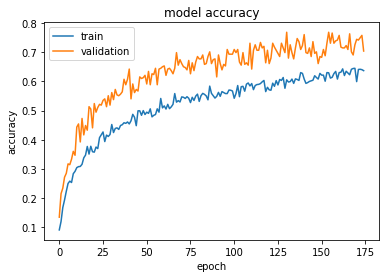

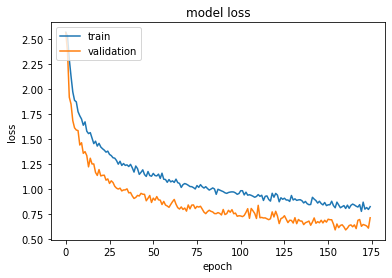

In [ ]:
LeNet4= Sequential()

# input
LeNet4.add(Input(shape=(64,64, 3)))

LeNet4.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet4.add(Conv2D(32, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet4.add(Conv2D(32, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet4.add(Conv2D(64, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))


LeNet4.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet4.add(Dense(64))
LeNet4.add(Activation('relu'))
LeNet4.add(Dropout(0.5))
LeNet4.add(Dense(13))
LeNet4.add(Activation('softmax'))

LeNet4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet4.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet4.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet4)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# LeNet with 3 hidden layers ADAM Optimizer Dropout  L2 Regularization and Leaky Relu
- L2 regularization is used just to make sure the model doesn't overfit, doesn't overfit even after adding more capacity

- Dropout is also used to make sure the the model doesn't overfit
- The perfomance is poorer if i use Leaky Relu, so I will stick to Relu activation function

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 32)       

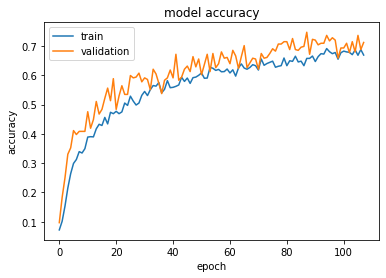

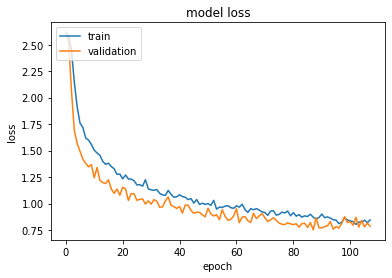

In [ ]:

#Leadky relu alpha value 0.1 is the most popular hyper parameter
leaky_relu_alpha = 0.1

LeNet5= Sequential()

# input
LeNet5.add(Input(shape=(64,64, 3)))
LeNet5.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

#fully connected layer
LeNet5.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet5.add(Dense(64))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(Dropout(0.5))
LeNet5.add(Dense(13))
LeNet5.add(Activation('softmax'))

LeNet5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet5.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet5.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet5)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 4 hidden layers Adam Optimizer and Leaky Relu L2 Regularization
- The model is **overfitting**.
- The model performs better than 3 hidden layers ADAM Optimizer Dropout L2 Regularization Leaky Relu.
- The problem with this model is that it is **very time consuming**, makin it not a feasible model.
- However, the LeNet model with 3 hidden layers ADAM Optimizer Dropout was a shallower model and achieved the same perfomance without regularizing

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)      

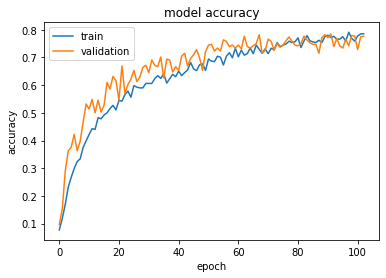

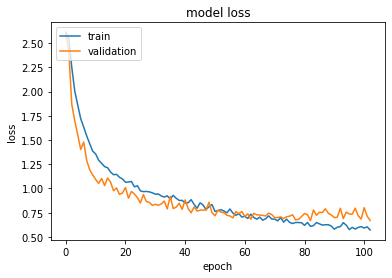

In [ ]:
#Leadky relu alpha value 0.1 is the most popular hyper parameter
leaky_relu_alpha = 0.1

LeNet6= Sequential()

# input
LeNet6.add(Input(shape=(64,64, 3)))

LeNet6.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 4
LeNet6.add(Conv2D(64, (3, 3)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))



LeNet6.add(Flatten()) 
#Fully Connected Layer
LeNet6.add(Dense(64))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(Dropout(0.5))
LeNet6.add(Dense(13))
LeNet6.add(Activation('softmax'))

LeNet6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet6.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet6.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet6)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 2 VGG Blocks,SGD Optimizer,Dropout,Relu Activation
- The model looks like it is **overfitting**.
- The training and validation curve
- Performs better than LeNet
- Next model, I will try with Adam Optimizer

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)            

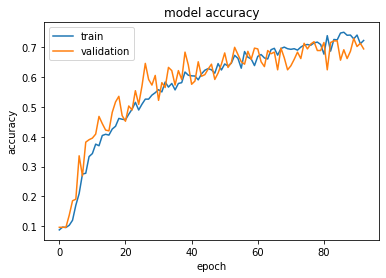

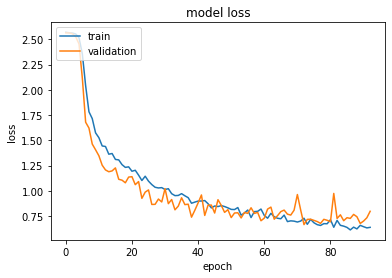

In [ ]:
model_vgg_2VGGBlocks= Sequential()
model_vgg_2VGGBlocks.add(Input(shape=(64,64, 3)))
model_vgg_2VGGBlocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))
#VGG BLOCK 2
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))

#Fully Connected Layer 1

model_vgg_2VGGBlocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))


model_vgg_2VGGBlocks.add(Dropout(0.5))
model_vgg_2VGGBlocks.add(Dense(13))
model_vgg_2VGGBlocks.add(Activation('softmax'))


model_vgg_2VGGBlocks.summary()


model_vgg_2VGGBlocks.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_2VGGBlocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_2VGGBlocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 2 VGG Blocks with Adam Optimizer Relu Activation Function
- The model is **not that overfitted anymore**


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)            

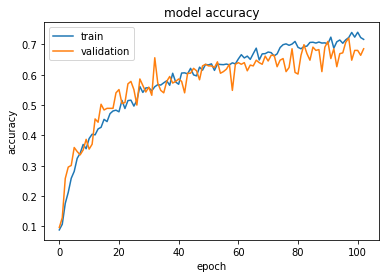

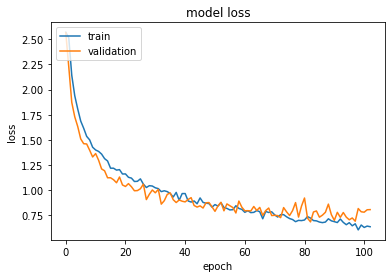

In [ ]:
model_vgg_2VGGBlocks= Sequential()
model_vgg_2VGGBlocks.add(Input(shape=(64,64, 3)))
model_vgg_2VGGBlocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))
#VGG BLOCK 2
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))

#Fully Connected Layer 1

model_vgg_2VGGBlocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))


model_vgg_2VGGBlocks.add(Dropout(0.5))
model_vgg_2VGGBlocks.add(Dense(13))
model_vgg_2VGGBlocks.add(Activation('softmax'))


model_vgg_2VGGBlocks.summary()


model_vgg_2VGGBlocks.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_2VGGBlocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_2VGGBlocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 3 VGG Blocks with Dropout
- The model is **not overfitting** anymore. 
- The fluctuations have gone away.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_13 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 64)      

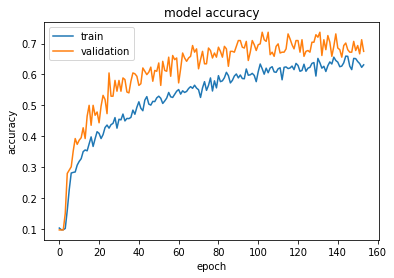

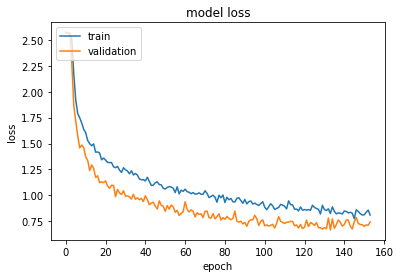

In [ ]:

model_vgg_3VGGblocks= Sequential()
model_vgg_3VGGblocks.add(Input(shape=(64,64, 3)))
model_vgg_3VGGblocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#VGG BLOCK 2
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#VGG BLOCK 3
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#Fully Connected Layer 1

model_vgg_3VGGblocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_3VGGblocks.add(Dense(512))
model_vgg_3VGGblocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_3VGGblocks.add(Dense(512))
model_vgg_3VGGblocks.add(Activation('relu'))


model_vgg_3VGGblocks.add(Dropout(0.5))
model_vgg_3VGGblocks.add(Dense(13))
model_vgg_3VGGblocks.add(Activation('softmax'))


model_vgg_3VGGblocks.summary()


model_vgg_3VGGblocks.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_3VGGblocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_3VGGblocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#Model VGG 3 Blocks with Adam Optimizer Dropout L2 Regularization
- Using random search experimenting with alpha [0.001,0.0005, 0.0001]
- **At alpha value = 0.0001 the best weighted F1 Score was achieved which was 0.73**
- I have repeated this experiment several times, most time F1-Score averages around weighted average F1-Score of 0.70.
- The results are similar to not using regularization. Moreover, it is doesn't make sense to use l2 regularization after observing this experiment because **the model was not overfitting in the first place** .


Alpha:0.001
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_27 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 14, 1

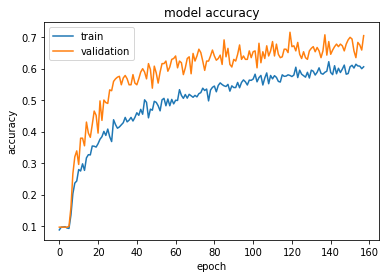

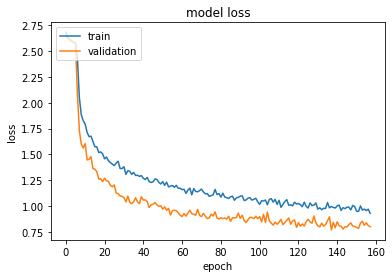

Alpha:0.0005
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_28 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 14, 

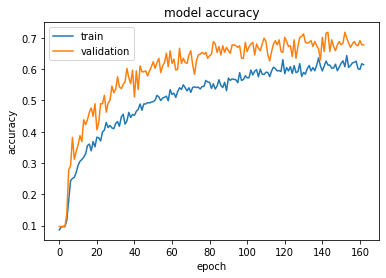

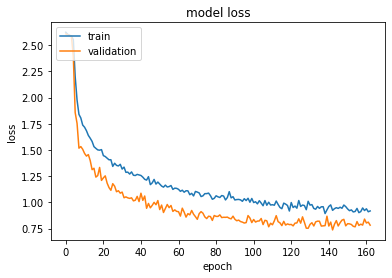

Alpha:0.0001
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_29 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 14, 

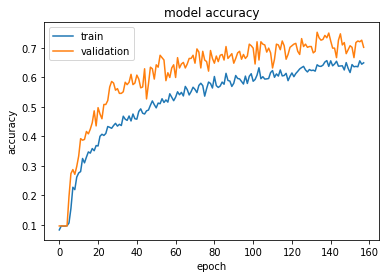

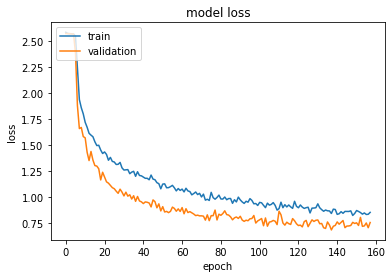

In [ ]:
alpha_list = [0.001,0.0005, 0.0001]
for alpha in alpha_list:
  print("Alpha:"+str(alpha))
  model_vgg_3VGGblocks_L2Reg= Sequential()
  model_vgg_3VGGblocks_L2Reg.add(Input(shape=(64,64, 3)))
  model_vgg_3VGGblocks_L2Reg.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

  #VGG BLOCK 1
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #VGG BLOCK 2
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #VGG BLOCK 3
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #Fully Connected Layer 1

  model_vgg_3VGGblocks_L2Reg.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model_vgg_3VGGblocks_L2Reg.add(Dense(512))
  model_vgg_3VGGblocks_L2Reg.add(Activation('relu'))

  #Fully Connected Layer 2
  model_vgg_3VGGblocks_L2Reg.add(Dense(512))
  model_vgg_3VGGblocks_L2Reg.add(Activation('relu'))


  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  model_vgg_3VGGblocks_L2Reg.add(Dense(13))
  model_vgg_3VGGblocks_L2Reg.add(Activation('softmax'))


  model_vgg_3VGGblocks_L2Reg.summary()


  model_vgg_3VGGblocks_L2Reg.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[categorical_accuracy])
  # Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
  monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
  history=model_vgg_3VGGblocks_L2Reg.fit_generator(generator=train_generator,
                      validation_data=validation_generator,
                      callbacks=[monitor],
                      epochs=250,
                      verbose=0
                      )

  # Evaluate the model on the original dataset
  evaluateModel(model_vgg_3VGGblocks_L2Reg)
  # Display Training Validation Accuracy and Loss Graphs
  displayPlots(history)

# ResNet Model Section


Defining Residual Block Class 
- Did not use the bottleneck layer because because my image shape (64,64,1), by using only 4 residual block my ResNet starts to overfit.
- The bottle neck in general is used for very deep networks like Resnet. In a shallow network like the one I am using for this project won't make much of a difference. 

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=.4)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=.4)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer="he_normal",
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=.4))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config

## get_resnet_model() generates the resnet model based on filters list and blocks list
- Had to modify it to handle 1 Channel images

In [ ]:
def get_resnet_model(filters, block_size, reg_lambda=0.0, fdropout=False):
  model = tf.keras.Sequential()

  #initial segment
  model.add(tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=(3, 3),
                                   strides=1,
                                   kernel_initializer="he_normal",
                                   kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                   padding="same", input_shape=(64,64, 3)))
  #Modification for handling one channel images
  model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
  model.add(tf.keras.layers.BatchNormalization(momentum=.4))

  #Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    model.add(ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda))
    
    for _ in range(1, nBlocks):
      model.add(ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda))

  # Final part
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(13, 
                                  activation=tf.nn.softmax, 
                                  kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                  kernel_initializer="he_normal"))

  return model

#Resnet Model with 6 Residual Blocks with SGD Optimizer with L2 Regularization
- Using Lambda Value =0.001
- The model is **underfitted**, I need to increase the capacity residual block from 2 to 3 blocks

Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
Confusion Matrix
[[35  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 1 39  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 30  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 31  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 23  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  3 35  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 43  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3 22  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 21  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6 27  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  2 32  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  2 17 16]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 33]]
Classification Report
              precision    recall  f1-score   support

         -15       0.95      0.95      0.95        37
         -30       0.95      0.85      0.90        46
         -45       0.79      0.75      0.77        40
         -60       0.76      0.89      0.82        35
         -75       0.82      0.88      0.85        26
     

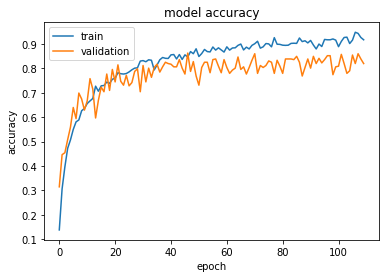

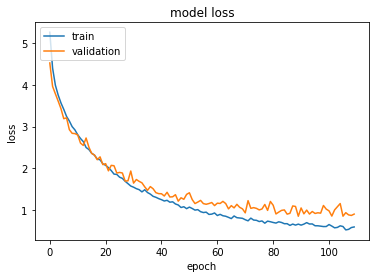

In [ ]:
model_resnet_2 = get_resnet_model([64, 128], [3, 3], reg_lambda=0.001)

model_resnet_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet_2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet_2)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# Resnet Model with 6 Blocks with Adam Optimizer with L2 Regularization
- Lambda value 0.001 was chosen after hyper parameter tuning.
- The model converges with epoch 78 faster than SGD which has epoch=140. 
- Using **Adam Optimizer in the rest of the resnet models because it converges faster**
- The model is **underfitted**, I need to increase the capacity residual block from 2 to 3 blocks

Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping
Confusion Matrix
[[34  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 2 40  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 33  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 30  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  4 21  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  3 35  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 41  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 22  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  8 29  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 10 23  7  0]
 [ 0  0  0  0  0  0  0  1  0  0  4 19 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 33]]
Classification Report
              precision    recall  f1-score   support

         -15       0.92      0.92      0.92        37
         -30       1.00      0.87      0.93        46
         -45       0.87      0.82      0.85        40
         -60       0.73      0.86      0.79        35
         -75       0.75      0.81      0.78        26
     

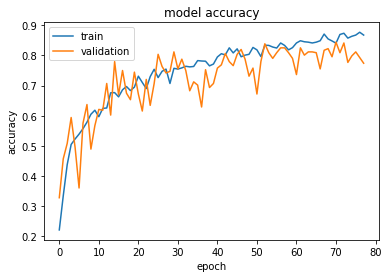

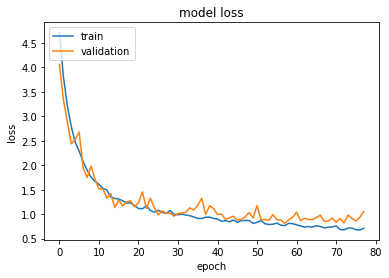

In [ ]:
model_resnet_2_ADAM = get_resnet_model([64, 128], [3, 3], reg_lambda=0.001)

model_resnet_2_ADAM.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet_2_ADAM.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet_2_ADAM)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# ResNet Model with 9 Residual Blocks with Adam Optimizer with L2 Regularization
- Lambda value 0.001 was chosen after hyper parameter tuning.
- - The model is **underfitted**, I need to increase the capacity residual block from 3 to 4 blocks

Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping
Confusion Matrix
[[35  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 8 37  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 37  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 27  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 22  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  3 35  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0 42  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 21  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 23  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13 26  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20 16  4  0]
 [ 0  0  0  0  0  0  0  0  0  1  5 21  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  4 31]]
Classification Report
              precision    recall  f1-score   support

         -15       0.78      0.95      0.85        37
         -30       0.95      0.80      0.87        46
         -45       0.95      0.93      0.94        40
         -60       0.93      0.77      0.84        35
         -75       0.69      0.85      0.76        26
     

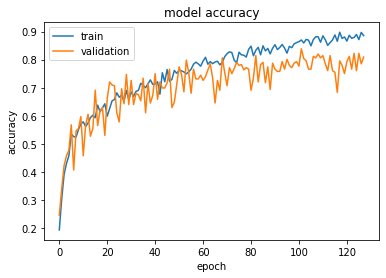

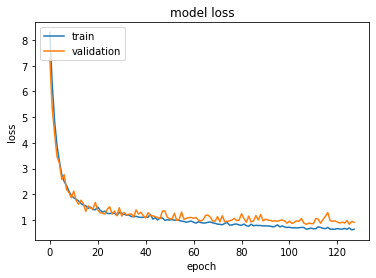

In [ ]:
model_resnet3 = get_resnet_model([64, 128, 256], [3, 3, 3], reg_lambda=0.001)

model_resnet3.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet3)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# ResNet Model with 12 Residual Blocks with Adam Optimizer with L2 Regularization
- Lambda value= 0.001 was chosen after hyper parameter tuning
- This is is the **best model**. 
- Because it achieved the **highest weighted average F1-Score of 0.84** 

Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
Confusion Matrix
[[35  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 2 41  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 35  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 32  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 18  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 36  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0 39  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 19  5  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3 28  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  3 33  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 24  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  9 26]]
Classification Report
              precision    recall  f1-score   support

         -15       0.88      0.95      0.91        37
         -30       0.93      0.89      0.91        46
         -45       0.90      0.88      0.89        40
         -60       0.86      0.91      0.89        35
         -75       0.82      0.69      0.75        26
     

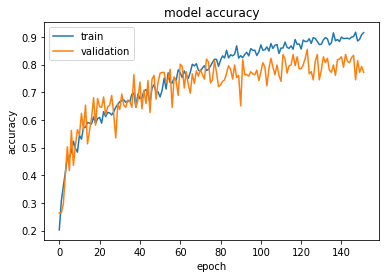

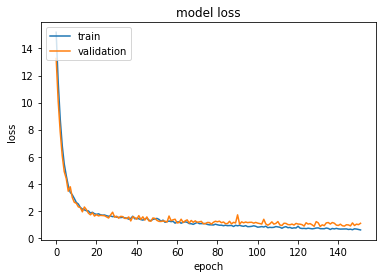

In [ ]:
model_resnet4 = get_resnet_model([64, 128, 256,512], [3, 3, 3,3], reg_lambda=0.001)

model_resnet4.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet4.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet4)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# ResNet Model with 15 Residual Blocks with Adam Optimizer with L2 Regularization
- Using Lambda value=0.001
- The weighted F1 average scored dropped from 0.84 to 0.82
- The model is **overfitted**.
- This model is a **huge model** and **very time consuming and hence **not feasible**.

Restoring model weights from the end of the best epoch.
Epoch 00162: early stopping
Confusion Matrix
[[35  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 3 42  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 30  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 30  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 17  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  3 35  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0 39  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 21  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  2 21  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  4 31  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  4 32  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 18  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  6 29]]
Classification Report
              precision    recall  f1-score   support

         -15       0.83      0.95      0.89        37
         -30       0.88      0.91      0.89        46
         -45       0.94      0.75      0.83        40
         -60       0.81      0.86      0.83        35
         -75       0.71      0.65      0.68        26
     

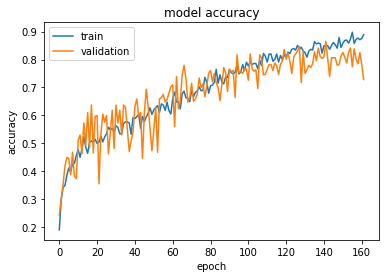

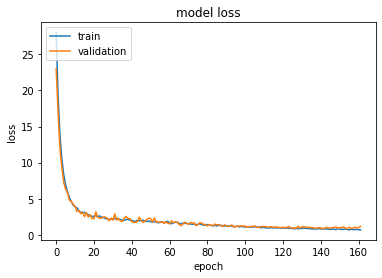

In [ ]:
model_resnet5 = get_resnet_model([64, 128, 256,512,1024], [3, 3, 3,3,3], reg_lambda=0.001)

model_resnet5.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet5.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet5)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#Using Random Search Hyper Parameter Tuning Resnet with 12 Residual Blocks
- The best model til now lambda value 0.001 gives highest weighted F1-Score of 0.96

lambda=0.01
Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
Confusion Matrix
[[29  2  0  0  0  0  6  0  0  0  0  0  0]
 [ 2 43  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 12 26  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  4 28  2  1  0  0  0  0  0  0  0]
 [ 0  0  0  2 13 11  0  0  0  0  0  0  0]
 [ 0  0  0  2  2 34  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 43  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 18  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  3 27  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  3 29  7  1]
 [ 0  0  0  0  0  0  0  0  0  1  4 23  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  9 25]]
Classification Report
              precision    recall  f1-score   support

         -15       0.94      0.78      0.85        37
         -30       0.75      0.93      0.83        46
         -45       0.84      0.65      0.73        40
         -60       0.82      0.80      0.81        35
         -75       0.76      0.50      0.60    

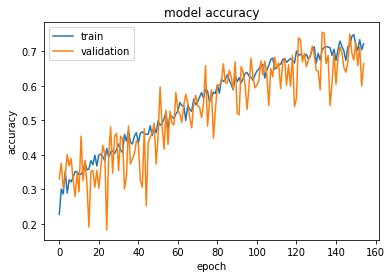

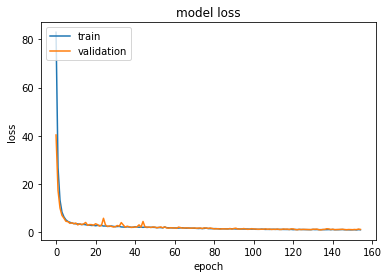

lambda=0.001
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
Confusion Matrix
[[35  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 2 41  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 36  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 20 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 34  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 44  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3 22  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  2 22  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2 35  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 12 24  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 21  6]
 [ 0  0  0  0  0  0  0  0  0  0  2  5 28]]
Classification Report
              precision    recall  f1-score   support

         -15       0.95      0.95      0.95        37
         -30       0.95      0.89      0.92        46
         -45       0.88      0.90      0.89        40
         -60       0.87      0.57      0.69        35
         -75       0.56      0.85      0.68   

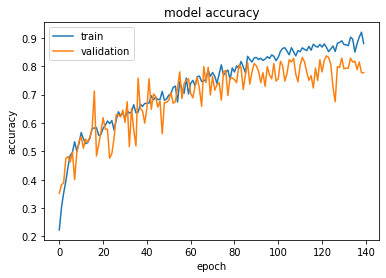

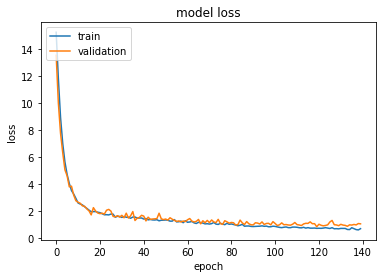

lambda=0.0001
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Confusion Matrix
[[31  3  0  0  0  0  3  0  0  0  0  0  0]
 [ 1 39  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 35  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  3 28  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 34  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0 41  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  4 20  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  7 16  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 16 16  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  3 33  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 23  4]
 [ 0  0  0  0  0  0  0  0  0  0  0 16 19]]
Classification Report
              precision    recall  f1-score   support

         -15       0.91      0.84      0.87        37
         -30       0.93      0.85      0.89        46
         -45       0.80      0.88      0.83        40
         -60       0.85      0.80      0.82        35
         -75       0.65      0.58      0.61  

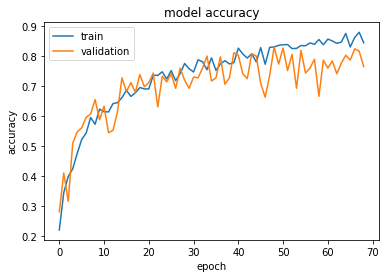

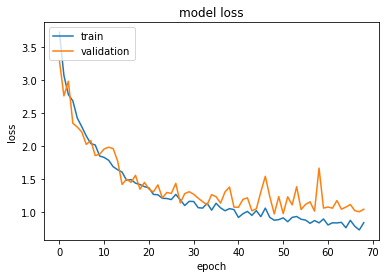

lambda=1e-05
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Confusion Matrix
[[33  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 1 45  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8 31  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  4 24  5  2  0  0  0  0  0  0  0]
 [ 0  0  0  1 15 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 38  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 43  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4 19  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 21  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  2 32  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  7 31  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 26  1]
 [ 0  0  0  0  0  0  0  0  0  0  2  9 24]]
Classification Report
              precision    recall  f1-score   support

         -15       0.94      0.89      0.92        37
         -30       0.83      0.98      0.90        46
         -45       0.89      0.78      0.83        40
         -60       0.92      0.69      0.79        35
         -75       0.75      0.58      0.65   

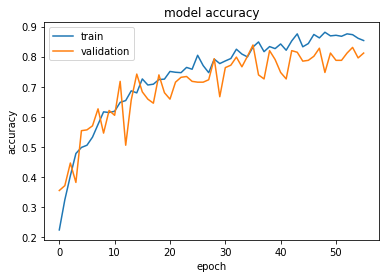

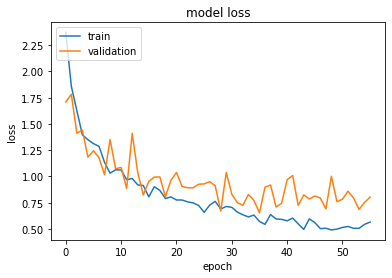

In [ ]:
lambda_vals = [0.01,0.001,0.0001,0.00001]

for reg_lambda in lambda_vals:
  print("lambda="+str(reg_lambda))
  model_resnet = get_resnet_model([64, 128, 256,512], [3, 3, 3,3], reg_lambda=reg_lambda)

  model_resnet.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

  # Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
  monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
  history=model_resnet.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

  # Evaluate the model on the original dataset
  evaluateModel(model_resnet)
  # Display Training Validation Accuracy and Loss Graphs
  displayPlots(history)



#Final Model Selected ResNet with 12 Residual Blocks with Adam Optimizer L2 Regularization
- The hyperparameter lambda =0.001 gives the best result out of all the models

Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
Confusion Matrix
[[34  1  0  0  0  0  2  0  0  0  0  0  0]
 [ 2 41  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 28  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 30  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 22  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 30  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 42  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  3 19  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 23  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11 21  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  2 30  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  3 27  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  7 28]]
Classification Report
              precision    recall  f1-score   support

         -15       0.92      0.92      0.92        37
         -30       0.87      0.89      0.88        46
         -45       0.88      0.70      0.78        40
         -60       0.77      0.86      0.81        35
         -75       0.67      0.85      0.75        26
     

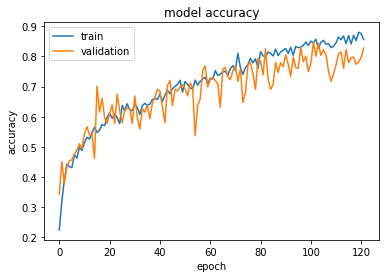

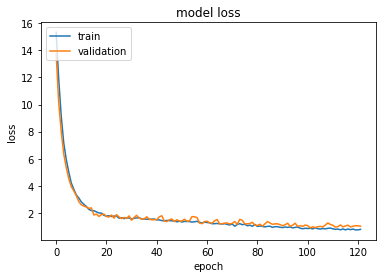

In [ ]:
final_model = get_resnet_model([64, 128, 256,512], [3, 3, 3,3], reg_lambda=0.001)
final_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=final_model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(final_model)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)


# Predicting the testing dataset

Checking the "test_data.csv" contents

In [ ]:
head_pose_test_data = pd.read_csv('test_data.csv',delimiter=',') 
head_pose_test_data.head(5)

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


Merging the dataframe based on "filename" to prepare the dataframe to feed it to the image generator

In [ ]:
temp_df = pd.merge(head_pose_test_data,dataframe_with_filenames,on="filename")

Preparing the dataframe to feed it to the image generator
and dropping the "person_id" and "series" column because they are unneccessary

In [ ]:
prediction_df = temp_df.drop(columns=['person_id', 'series'])
prediction_df.head(5)

,filename,image_path
0,face_33.jpg,modified_data/face_33.jpg
1,face_2148.jpg,modified_data/face_2148.jpg
2,face_2119.jpg,modified_data/face_2119.jpg
3,face_1262.jpg,modified_data/face_1262.jpg
4,face_516.jpg,modified_data/face_516.jpg


### Creating the testgenerator for test data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
predictionTestData_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 16


predictionTestDataGenerator = predictionTestData_datagen.flow_from_dataframe(
        dataframe=prediction_df,
        directory='./',
        x_col="image_path",
        y_col="filename",
        target_size=(64,64),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')

Found 465 validated image filenames belonging to 465 classes.


### Processing the Predictions

In [ ]:
predictionTestDataGenerator.reset()
predictions = final_model.predict_generator(predictionTestDataGenerator)


prediction_list = []
for i in range(0,len(predictions[:,0])):
  prediction_list.append(np.argmax(predictions[i]))
labels_predicted = np.asarray(prediction_list)



# Assigning the predictions with the appropriate labels
for i,j in enumerate(labels_predicted):
  if j ==0:
    labels_predicted[i] = "-15"
  if j ==1:
    labels_predicted[i] = '-30'
  if j ==2:
    labels_predicted[i] = '-45'
  if j ==3:
    labels_predicted[i] = '-60'
  if j ==4:
    labels_predicted[i] = '-75'
  if j ==5:
    labels_predicted[i] = '-90'
  if j ==6:
    labels_predicted[i] = '0'
  if j ==7:
    labels_predicted[i] = '15'
  if j ==8:
    labels_predicted[i] = '30'
  if j ==9:
    labels_predicted[i] = '45'
  if j ==10:
    labels_predicted[i] = '60'
  if j ==11:
    labels_predicted[i] = '75'
  if j ==12:
    labels_predicted[i] = '90'
   

print(labels_predicted)

[ 15 -30  15  15   0  75   0 -60  75  75   0 -90  75 -30  75 -90  30 -30
 -75  75   0   0   0 -90  15   0  75  75 -60   0  75   0 -15  15  75  90
   0  75   0 -90  15  15   0  75   0 -75   0  90  15  90   0  75  75  15
 -75 -90  75  15  15  75   0   0 -75  60   0 -45   0  90  75 -30   0  15
  90  15   0 -30  15   0   0   0  15   0 -90  90   0 -90  15   0 -30  75
 -90 -75  75 -90  90 -30 -90   0  90 -30   0 -15   0   0   0   0  15 -90
 -15 -60   0 -75  75   0   0   0   0   0  75  75  90 -60  60 -60  75 -15
  15 -90   0 -75  90  90  15   0   0 -30   0 -60 -60  15  75  75  75  75
  90   0  90  75  30  75 -90  15   0 -45  15   0   0 -60 -90  60  15 -30
   0   0  75 -75   0   0  90  90 -60  15  15   0  75 -45  90 -90  75   0
  15 -90   0   0  15   0  45  75 -45 -60 -75  75  30 -60 -75  45   0  90
  30  90  60 -60  15  75  45 -30   0   0 -30  75 -30  90  15   0 -75 -90
 -90  30  15 -15 -60 -75  90 -90  15  30  30 -90   0  30  90  15 -15 -75
 -75 -30  90 -75 -90 -45 -45  15 -60  75  75  60  1

Checking the predicted labels

In [ ]:
labels_predicted

array([ 15, -30,  15,  15,   0,  75,   0, -60,  75,  75,   0, -90,  75,
       -30,  75, -90,  30, -30, -75,  75,   0,   0,   0, -90,  15,   0,
        75,  75, -60,   0,  75,   0, -15,  15,  75,  90,   0,  75,   0,
       -90,  15,  15,   0,  75,   0, -75,   0,  90,  15,  90,   0,  75,
        75,  15, -75, -90,  75,  15,  15,  75,   0,   0, -75,  60,   0,
       -45,   0,  90,  75, -30,   0,  15,  90,  15,   0, -30,  15,   0,
         0,   0,  15,   0, -90,  90,   0, -90,  15,   0, -30,  75, -90,
       -75,  75, -90,  90, -30, -90,   0,  90, -30,   0, -15,   0,   0,
         0,   0,  15, -90, -15, -60,   0, -75,  75,   0,   0,   0,   0,
         0,  75,  75,  90, -60,  60, -60,  75, -15,  15, -90,   0, -75,
        90,  90,  15,   0,   0, -30,   0, -60, -60,  15,  75,  75,  75,
        75,  90,   0,  90,  75,  30,  75, -90,  15,   0, -45,  15,   0,
         0, -60, -90,  60,  15, -30,   0,   0,  75, -75,   0,   0,  90,
        90, -60,  15,  15,   0,  75, -45,  90, -90,  75,   0,  1

Preparing the dataframe

In [ ]:
pan_df = pd.DataFrame(labels_predicted,columns=["pan"])
final_pan_predictions =  pd.concat([prediction_df['filename'], pan_df], axis=1)
final_pan_predictions.head(10)

,filename,pan
0,face_33.jpg,15
1,face_2148.jpg,-30
2,face_2119.jpg,15
3,face_1262.jpg,15
4,face_516.jpg,0
5,face_1530.jpg,75
6,face_464.jpg,0
7,face_1971.jpg,-60
8,face_92.jpg,75
9,face_921.jpg,75


Checking the Predictions

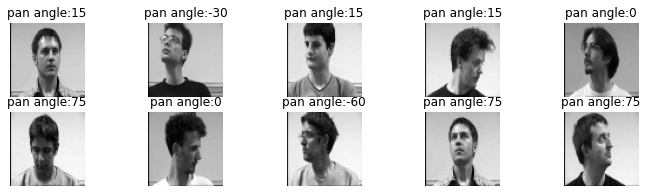

In [ ]:
from PIL import Image
random_image_list = dataframe.loc[np.random.choice(2325,10),'image_path']
plt.figure(figsize=(12,3))
for i, image_path in enumerate(random_image_list ):
    im = np.asarray(Image.open(image_path))
    plt.subplot(2,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.title("pan angle:"+str(final_pan_predictions['pan'][i]))

    plt.axis('off')  
plt.show()

# Please follow the below Instructions
1. **Make sure you run the "Assignment01_Tilt.ipynb" before running following segment of code because it will create the file 's3763175_predictions.csv'.**
2.  **Next, upload the file 's3763175_predictions_csv' in the same directory/folder where you extracted the "A1_data.zip" file ** **bold text**


Reads the "s3763175_predictions.csv" from the directory to a dataframe and merges the "pan angle predictions" to that dataframe using the merge function 

In [ ]:
prediction_file=pd.read_csv('s3763175_predictions.csv')
pan_predictions = pd.merge(prediction_file,final_pan_predictions,on='filename')

Writes the the pan angle predictions to the file

In [ ]:
pan_predictions.to_csv('s3763175_predictions.csv',index=False)